In [ ]:
import json
import sys
sys.path.append('/home/maxihuber/eeg-foundation')

tueg1 = '/itet-stor/maxihuber/deepeye_storage/index_files/half1_tueg_index2.json'
path_prefix = "/itet-stor/maxihuber/deepeye_storage/foundation/tueg/edf"
with open(tueg1, 'r') as f:
    tueg1 = json.load(f)
    
# Information Loading

for index_element in tueg1:
    if index_element["duration"] > 3_600:
        index_element["path"] = index_element["path"] if "itet-stor" in index_element["path"] else path_prefix + index_element["path"]
        print("Found!")
        break

channels = (
    index_element["good_channels"]
    if "good_channels" in index_element
    else index_element["channels"]
)

trial_idx = 0
trial_info = {
    "origin_path": index_element["path"],
    "num_channels": len(channels),
    "channels": channels,
    "origin_dur": index_element["duration"],
    "start": 0,
    "dur": 3_600,
    "sr": index_element["sr"],
    "ref": index_element["ref"],
    "Dataset": index_element["Dataset"],
    "SubjectID": index_element["SubjectID"],
}
        
# Storing
from src.utils.preloading.utils import (
    create_raw,
    load_edf_to_dataframe,
)

trial_info["new_path"] = f"/home/maxihuber/eeg-foundation/src/experiments/trial_{trial_idx}"
df = load_edf_to_dataframe(trial_info["origin_path"])
df = df[trial_info["channels"]]
start_sample = int(trial_info["start"] * trial_info["sr"])
end_sample = start_sample + int(trial_info["dur"] * trial_info["sr"])
df = df.iloc[start_sample:end_sample, :]
df.to_pickle(trial_info["new_path"] + ".pkl")
raw = create_raw(
    data=df, ch_names1=trial_info["channels"], sr=trial_info["sr"]
)
mne.export.export_raw(trial_info["new_path"] + ".edf", raw, fmt='edf', overwrite=True)
del raw, df
#raw.save(fname=trial_info["new_path"] + "_raw.fif", overwrite=True)

print(f"Orig. size: {format_size(os.path.getsize(trial_info['origin_path']))} (orig_dur={trial_info['origin_dur']})")
print(f"Pkl size: {format_size(os.path.getsize(trial_info['new_path'] + '.pkl'))}")
print(f"Edf size: {format_size(os.path.getsize(trial_info['new_path'] + '.edf'))}")

# Loading
channel_data_dict1 = load_from_path(
    path=trial_info["new_path"] + ".edf",
    channels=trial_info["channels"],
    sr=trial_info["sr"],
)
channel_data_dict2 = load_from_path(
    path=trial_info["new_path"] + ".pkl",
    channels=trial_info["channels"],
    sr=trial_info["sr"],
)

print(channel_data_dict1.keys())
print(channel_data_dict2.keys())

import matplotlib.pyplot as plt

plt.plot(channel_data_dict2['EEG FP1-LE'])
plt.show()

plt.plot(channel_data_dict2['EEG FP1-LE'])
plt.show()

In [4]:
import json

tueg = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'
with open(tueg, 'r') as f:
    tueg = json.load(f)

def get_generic_channel_name(channel_name):
    channel_name = channel_name.lower()
    # Remove "eeg " prefix if present
    if channel_name.startswith("eeg "):
        channel_name = channel_name[4:]
    # Simplify names with a dash and check if it ends with "-"
    if "-" in channel_name:
        if channel_name.endswith("-"):
            return "None"
        return channel_name.split("-")[0]
    return channel_name

chn_counts = {}
for ie in tueg:
    for chn in ie['channels']:
        chn = get_generic_channel_name(chn)
        if chn not in chn_counts:
            chn_counts[chn] = 0
        chn_counts[chn] += 1

print(chn_counts)


{'fp1': 69652, 'fp2': 69652, 'f3': 69651, 'f4': 69652, 'c3': 69654, 'c4': 69654, 'p3': 69650, 'p4': 69650, 'o1': 69650, 'o2': 69650, 'f7': 69652, 'f8': 69652, 't3': 69654, 't4': 69654, 't5': 69652, 't6': 69652, 'a1': 63233, 'a2': 63233, 'fz': 69413, 'cz': 69653, 'pz': 69411, 'roc': 23663, 'loc': 23662, 'ekg1': 53621, 't1': 58354, 't2': 58358, '26': 19609, '27': 19014, '28': 21323, '29': 22917, '30': 24541, 'oz': 12861, 'pg1': 12238, 'pg2': 12238, 'ekg': 13358, '31': 29349, '32': 29349, '23': 3179, '24': 3179, '20': 2599, '21': 2626, '22': 2626, '25': 4790, 'c3p': 23507, 'c4p': 23504, 'sp1': 29342, 'sp2': 28498, 'rlc': 2144, 'luc': 2144, '33': 323, '34': 323, '35': 323, '36': 323, '37': 323, '38': 323, '39': 323, '40': 323, '41': 323, '42': 323, '43': 323, '44': 323, '45': 323, '46': 323, '47': 323, '48': 323, '49': 323, '50': 323, '51': 323, '52': 323, '53': 323, '54': 323, '55': 323, '56': 323, '57': 323, '58': 323, '59': 323, '60': 323, '61': 323, '62': 323, '63': 323, '64': 323, '65

In [71]:
import pandas as pd
import mne

def load_from_path(path, channels, sr, chn=None):
    if path.endswith("edf"):
        eeg_data = mne.io.read_raw_edf(
            path,
            include=channels,
            preload=True,
        )
    elif path.endswith("pkl"):
        # Load DataFrame from pickle
        with open(path, "rb") as file:
            df = pd.read_pickle(file)
            eeg_data = create_raw(
                data=df,
                ch_names1=channels,
                sr=sr,
            )
    elif path.endswith("fif"):
        eeg_data = mne.io.read_raw_fif(path, preload=True)
    else:
        assert False, "Invalid path"

    # Add average reference
    eeg_data = avg_channel(eeg_data)

    if chn is not None:
        # return a numpy array for this channel
        for channel in eeg_data.ch_names:
            if channel != chn:
                continue
            idx = eeg_data.ch_names.index(channel)
            data, times = eeg_data[idx, :]
            data *= 1_000_000
            del eeg_data
            return data[0]

    else:
        # Datastructure to access data for each channel
        channel_data_dict = {}
        # Note: channel_data_dict also includes the AVG_REF channel
        for channel in eeg_data.ch_names:
            idx = eeg_data.ch_names.index(channel)
            data, times = eeg_data[idx, :]
            data *= 1_000_000  # Convert to uV
            # Flatten the data to 1D if required
            channel_data_dict[channel] = data.flatten()
        df = pd.DataFrame(channel_data_dict)
        df["Time in Seconds"] = times.flatten()
        return df

def avg_channel(raw):
    avg = raw.copy().add_reference_channels(ref_channels="AVG_REF")
    avg = avg.set_eeg_reference(ref_channels="average")
    return avg

In [5]:
pkl = '/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json'
with open(pkl, 'r') as f:
    pkl = json.load(f)

pkl1 = pkl[:int(len(pkl) * 2 / 3)]
pkl2 = pkl[int(len(pkl) * 2 / 3):]

assert len(pkl1) + len(pkl2) == len(pkl)

pkl1_path = '/itet-stor/maxihuber/deepeye_storage/index_files/twothird_pkl_index.json'
with open(pkl1_path, 'w') as f:
    json.dump(pkl1, f)

pkl2_path = '/itet-stor/maxihuber/deepeye_storage/index_files/onethird_pkl_index.json'
with open(pkl2_path, 'w') as f:
    json.dump(pkl2, f)

In [6]:
import os
import json
from tqdm import tqdm

path_prefix = "/itet-stor/maxihuber/deepeye_storage/foundation/tueg/edf"

def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} TB"

def get_index_info(index_path):
    with open(index_path, 'r') as f:
        index = json.load(f)

    total_sz = 0
    for ie in tqdm(index):
        file_path = ie["path"] if "itet-stor" in ie["path"] else path_prefix + ie["path"]
        total_sz += os.path.getsize(file_path)

    return total_sz

total_sz1 = get_index_info('/itet-stor/maxihuber/deepeye_storage/index_files/twothird_pkl_index.json')
print(f"Total size (tueg1): {format_size(total_sz1)}")

total_sz2 = get_index_info('/itet-stor/maxihuber/deepeye_storage/index_files/onethird_pkl_index.json')
print(f"Total size (tueg2): {format_size(total_sz2)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231640/231640 [01:44<00:00, 2210.60it/s]


Total size (tueg1): 254.34 GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115820/115820 [00:37<00:00, 3117.93it/s]


Total size (tueg2): 118.56 GB


In [14]:
def get_file_info(root_dir):
    edf_count = 0
    pkl_count = 0
    edf_size = 0
    pkl_size = 0

    for _, (subdir, _, files) in tqdm(enumerate(os.walk(root_dir))):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file.endswith("edf"):
                edf_count += 1
                edf_size += os.path.getsize(file_path)
            elif file.endswith("pkl"):
                pkl_count += 1
                pkl_size += os.path.getsize(file_path)

    return edf_count, edf_size, pkl_count, pkl_size

root_dir = "/dev/shm/mae"
edf_count, edf_size, pkl_count, pkl_size = get_file_info(root_dir)

print(f"Total number of .edf files: {edf_count}")
print(f"Total size of .edf files: {format_size(edf_size)}")
print(f"Total number of .pkl files: {pkl_count}")
print(f"Total size of .pkl files: {format_size(pkl_size)}")

9it [00:00, 268.26it/s]

Total number of .edf files: 6327
Total size of .edf files: 117.38 GB
Total number of .pkl files: 27
Total size of .pkl files: 4.70 GB


In [34]:
import json

tueg_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index2.json'
with open(tueg_path, 'r') as f:
    tueg = json.load(f)

tueg1 = tueg[:len(tueg)//2]
tueg2 = tueg[len(tueg)//2:]
assert len(tueg1) + len(tueg2) == len(tueg)

tueg1_path = '/itet-stor/maxihuber/deepeye_storage/index_files/half1_tueg_index2.json'
tueg2_path = '/itet-stor/maxihuber/deepeye_storage/index_files/half2_tueg_index2.json'

with open(tueg1_path, 'w') as f:
    json.dump(tueg1, f)

with open(tueg2_path, 'w') as f:
    json.dump(tueg2, f)

In [1]:
import os
import time
import json
import random

import sys
sys.path.append("/home/maxihuber/eeg-foundation")

import torch
import torchaudio
import torch.nn.functional as F

from src.data.mae_rope_datamodule import TrainDataModule
from src.utils.preloading.utils import (
    filter_index_simple,
    info_from_index,
    load_trials,
)
from src.data.generate_batches import BatchGenerator
from src.data.mae_rope_dataset import RawDataset
from src.data.mae_rope_distributedsampler import PresampledDistributedSampler

from sklearn.model_selection import train_test_split
from src.data.transforms import (
    crop_spg,
    custom_fft,
    normalize_spg,
)

import matplotlib.pyplot as plt

In [2]:
self = TrainDataModule(source_indices=["/itet-stor/maxihuber/deepeye_storage/index_files/tuab_train_index2.json"], 
                       path_prefix="/itet-stor/maxihuber/deepeye_storage/foundation/tueg/edf",
                       channel_name_map_path="/home/maxihuber/eeg-foundation/src/data/components/channels_to_id2.json")

#### File information ################################################################################

index = filter_index_simple(
    index_paths=self.source_indices,
    path_prefix=self.path_prefix,
    min_duration=self.min_duration,
    max_duration=self.max_duration,
    discard_sr=self.discard_sr,
    discard_datasets=self.discard_datasets,
)

index = index[:100]

trial_info_index = info_from_index(
    index_chunk=index,
    min_duration=self.min_duration,
    max_duration=self.max_duration,
    split_duration=self.split_duration,
)

full_channel_index = {}
num_signals = 0
data_seconds = 0
nr_trials_excluded = 0

for trial_idx, trial_info in trial_info_index.items():
    for chn in trial_info["channels"]:
        full_channel_index[num_signals] = {
            "channel": chn,
            "sr": trial_info["sr"],
            "dur": trial_info["dur"],
            "path": trial_info["origin_path"],
            "trial_idx": trial_idx,
            "Dataset": trial_info["Dataset"],
            "SubjectID": trial_info["SubjectID"],
        }
        num_signals += 1
        data_seconds += trial_info["dur"]

print(f"[setup] We have data from {len(trial_info_index)} trials.", file=sys.stderr)
print(f"[setup] This is {int(data_seconds)} seconds (single-channel).", file=sys.stderr)
print(f"[setup] We excluded {nr_trials_excluded} test trials.", file=sys.stderr)

# Group channels in subset_indices by (subject, trial)
id_to_sr_to_trial_to_channels = {}
for channel_idx, channel_info in full_channel_index.items():
    subject_id = channel_info["SubjectID"]
    sr = channel_info["sr"]
    trial_idx = channel_info["trial_idx"]
    if subject_id not in id_to_sr_to_trial_to_channels:
        id_to_sr_to_trial_to_channels[subject_id] = {
            sr: {trial_idx: [channel_idx]}
        }
    elif sr not in id_to_sr_to_trial_to_channels[subject_id]:
        id_to_sr_to_trial_to_channels[subject_id][sr] = {
            trial_idx: [channel_idx]
        }
    elif trial_idx not in id_to_sr_to_trial_to_channels[subject_id][sr]:
        id_to_sr_to_trial_to_channels[subject_id][sr][trial_idx] = [channel_idx]
    else:
        id_to_sr_to_trial_to_channels[subject_id][sr][trial_idx].append(
            channel_idx
        )

print(f"[setup] # Full-Subjects: {len(id_to_sr_to_trial_to_channels)}", file=sys.stderr)

#### Batch generation ################################################################################

self.batch_generator = BatchGenerator(
    patch_size=self.patch_size,
    win_shifts=self.win_shifts,
    win_shift_factor=self.win_shift_factor,
    max_nr_patches=self.max_nr_patches,
    seed=0,
    epoch=0,
)
start_time = time.time()
batch_indices = self.batch_generator.generate_batches(
    id_to_sr_to_trial_to_channels, full_channel_index
)

print(f"[generate_batches] # GenerateBatches took: {round(time.time() - start_time,2)}s", file=sys.stderr)
print(f"[setup] # Batches (total): {len(batch_indices)}", file=sys.stderr)

slurm_rank = int(os.getenv("SLURM_PROCID", "0"))
slurm_size = int(os.getenv("SLURM_NPROCS", "1"))

batches_per_process = len(batch_indices) // slurm_size
new_total_batches = batches_per_process * slurm_size
batch_indices = batch_indices[:new_total_batches]

start_index = slurm_rank * batches_per_process
end_index = start_index + batches_per_process

batch_indices = batch_indices[start_index:end_index]

# Now, load data that this process will access into memory
trial_idxs = sorted(
    set(
        [
            full_channel_index[channel_idx]["trial_idx"]
            for batch in batch_indices
            for (channel_idx, _, _) in batch
        ]
    )
)
trunc_trial_info_index = {
    trial_idx: trial_info_index[trial_idx] for trial_idx in trial_idxs
}

#### Data loading ####################################################################################

trial_index = load_trials(trunc_trial_info_index)


#### Dataset & Sampler Creation ######################################################################

# Train/Test split of the batches
keys = list(range(len(batch_indices)))
train_keys, val_keys = train_test_split(
    keys,
    train_size=self.train_val_split[0],
    test_size=self.train_val_split[1],
    random_state=42,
)
train_batches = [batch_indices[key] for key in train_keys]
val_batches = [batch_indices[key] for key in val_keys]
print(f"[setup] # Train/Test Batches [rank={slurm_rank}]: {len(train_batches)}, {len(val_batches)}", file=sys.stderr)

self.train_dataset = RawDataset(
    channel_index=full_channel_index, trial_index=trial_index
)
self.val_dataset = RawDataset(
    channel_index=full_channel_index, trial_index=trial_index
)

[filter_index_simple] Filtering data dir
Filtering index: 2717it [00:00, 825612.11it/s]
[filter_index_simple] files found in total: 2717
[filter_index_simple] files selected per index: {'/itet-stor/maxihuber/deepeye_storage/index_files/tuab_train_index2.json': 2716}
[filter_index_simple] files selected in total: 2717
Starting to save the trials locally
Loading data information: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 165651.82it/s]
[load_from_index] Read 100 trials on process.
[setup] We have data from 100 trials.
[setup] This is 3227559 seconds (single-channel).
[setup] We excluded 0 test trials.
[setup] # Full-Subjects: 79
Generating batches: 100%|████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1489.76it/s]
[generate_batches] # GenerateBatches took: 0.06s
[setup] # Batches (total): 988
Loading data: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00

In [3]:
# Manually get the first batch
batch = [self.train_dataset.__getitem__(sample) for sample in train_batches[0]]

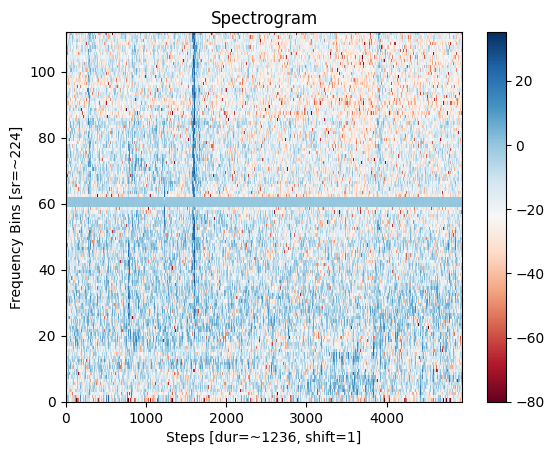

In [32]:
def plot_signal(signal):
    signal = signal.numpy()
    plt.plot(signal)
    plt.show()

tmp = """
def plot_spg(spg, sr, dur):
    plt.pcolormesh(spg, shading="auto", cmap="RdBu")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Steps")
    plt.title(f"Spectrogram: [sr={sr}, dur={dur}]")
    plt.colorbar(label="")
    plt.show()
"""

def plot_spg(spg, title, shift):
    sr = int(2 * (spg.shape[0]) / shift)
    dur = int((spg.shape[1]) * shift * 0.25)
    plt.pcolormesh(spg, shading="auto", cmap="RdBu")
    plt.title(title)
    plt.ylabel(f"Frequency Bins [sr=~{sr}]")
    plt.xlabel(f"Steps [dur=~{dur}, shift={shift}]")
    plt.colorbar(label="")

def snake_collate_fn(self, batch):

    batch_len = len(batch)

    srs = [sample["sr"] for sample in batch]
    assert all(
        sr == srs[0] for sr in srs
    ), f"[snake_collate_fn] Differing sampling rates within batch, srs={srs}"

    sr = srs[0]
    durs = [sample["dur"] for sample in batch]
    min_dur = min(durs)

    # Randomly sample a win_size for the STFT
    valid_win_shifts = [
        win_shift
        for win_shift in self.win_shifts
        if self.batch_generator.get_nr_y_patches(win_shift, sr) >= 1
        and self.batch_generator.get_nr_x_patches(win_shift, min_dur) >= 1
    ]
    assert (
        len(valid_win_shifts) > 0
    ), f"[snake_collate_fn] No valid valid_win_shifts found, {[sample['sr'] for sample in batch]}, {[sample['dur'] for sample in batch]}"

    # print("[snake_collate_fn] Sampling set:", valid_win_shifts, file=sys.stderr)
    win_size = random.choice(valid_win_shifts)
    win_size = 1

    fft = torchaudio.transforms.Spectrogram(
        n_fft=int(sr * win_size),
        win_length=int(sr * win_size),
        hop_length=int(sr * win_size * self.win_shift_factor),
        normalized=True,
    )

    spgs = []  # Spectrograms of this batch
    chns = []  # List to store channel tensors for each patch
    spgs_w = set()  # Widths of the spectrograms

    H, W = 0, 0

    for i, sample in enumerate(batch):

        signal = sample["signal"]
        
        channel_name = self.get_generic_channel_name(sample["channel"])
        if channel_name in self.channel_name_map:
            p = random.random()  # Sample p from a uniform distribution over [0, 1)
            channel = (
                self.channel_name_map[channel_name]
                if p > self.none_channel_probability
                else self.channel_name_map["None"]
            )
        else:
            channel = self.channel_name_map["None"]

        # STFT
        spg = fft(signal)
        spg = spg**2
        spg = crop_spg(spg, self.patch_size)

        H_new, W_new = spg.shape[0], spg.shape[1]
        h_new, w_new = H_new // self.patch_size, W_new // self.patch_size

        # Create a tensor filled with the current channel value
        channel_tensor = torch.full((h_new, w_new), channel, dtype=torch.float32)

        spgs.append(spg)
        chns.append(channel_tensor)
        spgs_w.add(w_new)

        H = H_new
        W += W_new

    total_patches = H * W // (self.patch_size**2)

    # wait for cuda crash, not assertion crash
    # assert (
    #     total_patches <= self.max_nr_patches
    # ), f"Total patches: {total_patches}, Max patches: {self.max_nr_patches}"

    h, w = H // self.patch_size, W // self.patch_size
    
    # Now, given the H, W information, we can create a tensor of desired shape
    batch_size = batch_len

    spgs_rows = []
    chns_rows = []
    means_rows = []
    stds_rows = []

    row_size = W // batch_size

    cur_spgs = []
    cur_chns = []
    cur_means = []
    cur_stds = []
    cur_W = 0

    for i_, (spg, chn) in enumerate(zip(spgs, chns)):
        if cur_W + spg.shape[1] <= row_size:
            # Can use full spg
            spg, mean, std = normalize_spg(spg)
            if i_ == 0:
                plot_spg(spg, "Spectrogram", win_size)
            mean = self.encode_mean(mean, win_size)
            std = self.encode_mean(std, win_size)
            cur_spgs.append(spg)
            cur_chns.append(chn)
            cur_means.append(mean)
            cur_stds.append(std)
            cur_W += spg.shape[1]
            if cur_W == row_size:
                cur_W = 0
                spgs_rows.append(cur_spgs)
                chns_rows.append(cur_chns)
                means_rows.append(cur_means)
                stds_rows.append(cur_stds)
                cur_spgs = []
                cur_chns = []
                cur_means = []
                cur_stds = []
        else:
            # Need to split this spg to multiple rows
            #  in a while loop
            spg_W = spg.shape[1]
            spg_W_taken = 0
            while spg_W > 0:
                take_W = min(spg_W, row_size - cur_W)
                spg_chunk = spg[:, spg_W_taken : spg_W_taken + take_W]
                chn_chunk = chn[
                    :,
                    (spg_W_taken // self.patch_size) : (
                        (spg_W_taken + take_W) // self.patch_size
                    ),
                ]
                spg_chunk, mean_chunk, std_chunk = normalize_spg(spg_chunk)
                mean_chunk = self.encode_mean(mean_chunk, win_size)
                std_chunk = self.encode_mean(std_chunk, win_size)
                cur_spgs.append(spg_chunk)
                cur_chns.append(chn_chunk)
                cur_means.append(mean_chunk)
                cur_stds.append(std_chunk)
                spg_W -= take_W
                cur_W += take_W
                spg_W_taken += take_W
                cur_W %= row_size
                if cur_W == 0:
                    spgs_rows.append(cur_spgs)
                    chns_rows.append(cur_chns)
                    means_rows.append(cur_means)
                    stds_rows.append(cur_stds)
                    cur_spgs = []
                    cur_chns = []
                    cur_means = []
                    cur_stds = []

    # Concatenate rows
    final_batch = torch.stack([torch.cat(row, dim=-1) for row in spgs_rows])
    channels = torch.stack([torch.cat(row, dim=-1) for row in chns_rows])

    max_nr_mean_patches = max([len(means) for means in means_rows])
    means_rows = [torch.cat(means, dim=-1) for means in means_rows]
    means_rows = [
        F.pad(
            means,
            (0, max_nr_mean_patches - means.shape[1]),
            mode="constant",
            value=0,
        )
        for means in means_rows
    ]
    means = torch.stack(means_rows)

    stds_rows = [torch.cat(std, dim=-1) for std in stds_rows]
    stds_rows = [
        F.pad(
            stds,
            (0, max_nr_mean_patches - stds.shape[1]),
            mode="constant",
            value=0,
        )
        for stds in stds_rows
    ]
    stds = torch.stack(stds_rows)

    assert (
        final_batch.shape[1] == channels.shape[1] * self.patch_size
    ), f"Batch shape: {final_batch.shape[1]}, Channels shape: {channels.shape[1]*self.patch_size}"
    assert (
        final_batch.shape[2] == channels.shape[2] * self.patch_size
    ), f"Batch shape: {final_batch.shape[2]}, Channels shape: {channels.shape[2]*self.patch_size}"

    final_batch.unsqueeze_(1)

    # Flatten the channels tensor, the batch will be automatically by the network
    channels = channels.flatten(1)
    means = means.transpose(1, 2)
    stds = stds.transpose(1, 2)

    B, C, H, W = final_batch.shape

    # Send the constructed batch to the network
    # print(f"[return] final_batch.shape: {final_batch.shape}", file=sys.stderr)
    # print(f"[return] channels.shape: {channels.shape}", file=sys.stderr)
    # print(f"[return] means.shape: {means.shape}", file=sys.stderr)
    # print(f"[return] win_size: {win_size}", file=sys.stderr)

    return {
        "batch": final_batch,
        "channels": channels,
        "means": means,
        "stds": stds,
        "win_size": win_size,
    }

x = snake_collate_fn(self=self, batch=batch)